In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import RBFInterpolator
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from helpers import *

## Read in PCM LBL data

In [2]:
# Load data generated by PCM_LBL
data = np.load("forcing_arr.npz")
CO2_data = data['CO2']
albedo_data = data['albedo']
T_data = data['T']

In [3]:
# compute interpolator
log_pCO2 = np.log(CO2_data)
points = np.column_stack((log_pCO2, albedo_data))
interpolator = RBFInterpolator(points, T_data, kernel='quintic', smoothing=1.0)

# define function
get_T = lambda pCO2, albedo: interpolator(np.array([[np.log(pCO2), albedo]]))[0]

## Annotated interpolated plot

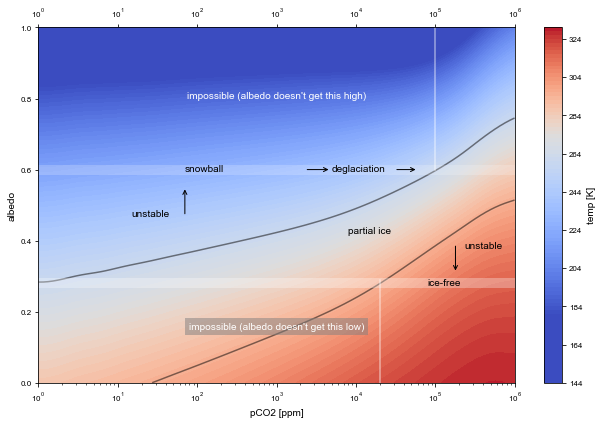

In [4]:
# grid for plotting
CO2_plot = np.logspace(0, 6, 100)
albedo_plot = np.linspace(0, 1, 100)
CO2_grid, albedo_grid = np.meshgrid(CO2_plot, albedo_plot)
query_points = np.column_stack((np.log(CO2_grid.ravel()), albedo_grid.ravel()))
T_interp = interpolator(query_points).reshape(CO2_grid.shape)

fig,ax = plt.subplots(figsize=(10,6))

norm = colors.TwoSlopeNorm(vmin=min(T_data), vcenter=273, vmax=max(T_data))
cf = ax.contourf(CO2_grid, albedo_grid, T_interp, levels=100,cmap='coolwarm', norm=norm)

cs = ax.contour(CO2_grid, albedo_grid, T_interp, levels=[260, 295],colors='k', alpha=0.5)
#ax.contour(CO2_grid, albedo_grid, T_interp, levels=[273,288],colors='grey', alpha=0.5)

cbar = plt.colorbar(cf)
cbar.set_label('temp [K]')

# --- annotations ---

#ax.set_ylim(0,0.9)

ai = 0.6 # ice-covered albedo
ax.axhline(ai,c='w',alpha=0.2,linewidth=10)

ao = 0.28 # ice-free albedo
ax.axhline(ao,c='w',alpha=0.3,linewidth=10)

ax.text(0.5, 0.8/ax.get_ylim()[1], "impossible (albedo doesn't get this high)",
        c='w', ha='center', transform=ax.transAxes)
ax.text(0.5, 0.15/ax.get_ylim()[1], "impossible (albedo doesn't get this low)",
        c='w', ha='center', transform=ax.transAxes,
        bbox=dict(facecolor='grey', alpha=0.5, edgecolor='none'))

ax.text(70,ai-0.005,'snowball',c='k')
ax.annotate('',xy=(4.8e3,ai),xytext=(2.3e3,ai),arrowprops=dict(color='k',arrowstyle='->'))
ax.text(5e3,ai-0.005,'deglaciation')
ax.annotate('',xy=(6e4,ai),xytext=(3.1e4,ai),arrowprops=dict(color='k',arrowstyle='->'))

text_y = 0.47
ax.text(15,text_y,'unstable',c='k')
arrow_x = 70
arrow_len = 0.08
ax.annotate('',xy=(arrow_x,text_y+arrow_len),xytext=(arrow_x,text_y),
            arrowprops=dict(color='k',arrowstyle='->'))
ax.text(8e3,0.42,'partial ice',c='k')

text_y = 0.38
ax.text(2.3e5,text_y,'unstable',c='k')
arrow_x = 1.8e5
ax.annotate('',xy=(arrow_x,text_y-arrow_len+0.01),xytext=(arrow_x,text_y+0.01),
            arrowprops=dict(color='k',arrowstyle='->'))
ax.text(8e4,ao-0.005,'ice-free',c='k')

ax.axvline(2e4,0,0.29/ax.get_ylim()[1],c='w',alpha=0.5)
ax.axvline(1e5,0.6/ax.get_ylim()[1],1,c='w',alpha=0.5)

ax.set_xscale('log')
ax.set_xlabel('pCO2 [ppm]')
ax.set_ylabel('albedo')
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
        
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

## Solving for pCO2

In [5]:
from ice_albedo import *

In [6]:
### initial conditions -- defunct scheme

# inverted interpolator
inv_points = np.column_stack((T_data, albedo_data))
inv_interpolator = RBFInterpolator(inv_points, log_pCO2, kernel='quintic', smoothing=1.0)

get_pCO2 = lambda T, albedo: np.exp(inv_interpolator(np.array([[T, albedo]]))[0])

# find stable conditions -- this is a guess, superceded by root finding method
def get_conditions(T,verbose=False):
    albedo_stable = albedo_scalar(T)
    pCO2 = get_pCO2(T,albedo_stable)
    if verbose:
        print(f"pCO2 = {pCO2:0.0f} ppm")
        print(f"albedo = {albedo_stable:0.2f}")
    return pCO2,albedo
    
get_conditions(288,verbose=True)
print(f"Deglaciation at {get_conditions(260)[0]/1e6:0.1f} bar")

pCO2 = 9003 ppm
albedo = 0.29
Deglaciation at 0.1 bar


In [7]:
# scheme in use
def get_conditions(T, pCO2_min=1, pCO2_max=1e6, verbose=False):
    # calculate albedo
    albedo_stable = albedo(T)
    
    # residual function
    def residual(pCO2):
        return get_T(pCO2, albedo_stable) - T
    
    # evaluate at endpoints
    fa = residual(pCO2_min)
    fb = residual(pCO2_max)
    
    # check if the values have opposite signs
    if fa * fb > 0:
        raise ValueError(f"No sign change in the bracket:\nf(pCO2_min) = {fa:0.0f}, f(pCO2_max) = {fb:0.0f}. ")
    
    # solve for pCO2 such that residual(pCO2) = 0
    pCO2_solution = root_scalar(residual, bracket=[pCO2_min, pCO2_max], method='brentq')
    
    if pCO2_solution.converged:
        pCO2 = pCO2_solution.root
        if verbose:
            print(f"pCO2 = {pCO2:0.0f} ppm")
            print(f"albedo = {albedo_stable:0.2f}")
        return pCO2, albedo_stable
    else:
        raise RuntimeError(f"Root finding did not converge for T = {T:0.0f}")
        
get_conditions(288,verbose=True)
print(f"Deglaciation at {get_conditions(260)[0]/1e6:0.1f} bar")

pCO2 = 9138 ppm
albedo = 0.29
Deglaciation at 0.1 bar


## Bifurcation plot for paper

In [8]:
# stable equilibria
T_stable = np.linspace(227, 400, 500)
T_stable_arr = []
pCO2_stable_arr = []
albedo_stable_arr = []
for T in T_stable:
    try:
        pCO2_stable, albedo_stable = get_conditions(T)
        if pCO2_stable <= ax.get_xlim()[1]:
            T_stable_arr.append(T)
            pCO2_stable_arr.append(pCO2_stable)
            albedo_stable_arr.append(albedo_stable)
    except ValueError:
        continue
        
print(len(T_stable_arr))

259


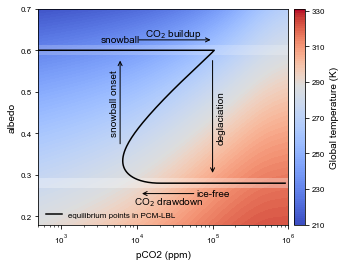

In [10]:
# grid for plotting
CO2_plot = np.logspace(0, 6, 100)
albedo_plot = np.linspace(0, 1, 100)
CO2_grid, albedo_grid = np.meshgrid(CO2_plot, albedo_plot)
query_points = np.column_stack((np.log(CO2_grid.ravel()), albedo_grid.ravel()))
T_interp = interpolator(query_points).reshape(CO2_grid.shape)

# plot
fig = plt.figure(figsize=(4.18, 3))
ax = fig.add_axes([0, 0, 1, 1])

# temperature contour
min_temp = 210
max_temp = 330+1
norm = colors.TwoSlopeNorm(vmin=min_temp, vcenter=288, vmax=max_temp)
levels = np.linspace(min_temp, max_temp, 100)
cf = ax.contourf(CO2_grid, albedo_grid, T_interp, levels=levels,cmap='coolwarm', norm=norm)

# colorbar
cbar = plt.colorbar(cf, pad=0.02)
cbar.set_label('Global temperature (K)')
cbar.set_ticks(np.arange(min_temp,max_temp,20))

# --- annotations ---
ann_color='k'

ai = 0.6 # ice-covered albedo
ax.axhline(ai,c='w',alpha=0.2,linewidth=10)

ao = 0.28 # ice-free albedo
ax.axhline(ao,c='w',alpha=0.3,linewidth=10)

snowball_y = ai+0.025
deglaciation_y = ao-0.025
snowball_x = 6e3
deglaciation_x = 1e5

# snowball transition
arrow_start = 0.37
arrow_end = 0.58
ax.annotate('',xy=(snowball_x,arrow_end),xytext=(snowball_x,arrow_start),arrowprops=dict(color=ann_color,arrowstyle='->'))
ax.text(5e3, (arrow_start+arrow_end)/2, 'snowball onset', c=ann_color, rotation='vertical', va='center', ha='center')

# snowball & CO2 buildup
ax.text(snowball_x,snowball_y-0.005, 'snowball', c=ann_color, ha='center')
ax.annotate('',xy=(deglaciation_x,snowball_y),xytext=(snowball_x+4e3,snowball_y),arrowprops=dict(color=ann_color,arrowstyle='->'))
ax.text(3e4,snowball_y+0.01, 'CO$_2$ buildup', c=ann_color, ha='center')

# deglaciation
arrow_start = 0.58
arrow_end = 0.3
ax.annotate('',xy=(deglaciation_x,arrow_end),xytext=(deglaciation_x,arrow_start),arrowprops=dict(color=ann_color,arrowstyle='->'))
ax.text(1.3e5, (arrow_start+arrow_end)/2, 'deglaciation', c=ann_color, rotation='vertical', va='center', ha='center')

# ice free & drawdown
ax.text(deglaciation_x,deglaciation_y-0.005, 'ice-free', c=ann_color, ha='center')
ax.annotate('',xy=(snowball_x+5e3,deglaciation_y),xytext=(deglaciation_x-4e4,deglaciation_y),arrowprops=dict(color=ann_color,arrowstyle='->'))
ax.text(2.6e4,deglaciation_y-0.025, 'CO$_2$ drawdown', c=ann_color, ha='center')

# stable equilibria
ax.plot(pCO2_stable_arr, albedo_stable_arr, c='k', label='equilibrium points in PCM-LBL')
ax.legend(loc='lower left',facecolor='none',edgecolor='none')

# --- formatting --- 

ax.set_xscale('log')
ax.set_xlabel('pCO2 (ppm)')
ax.set_ylabel('albedo')
ax.set_xlim(5e2,1e6)
ax.set_ylim(ao-0.1,ai+0.1)

figname="bifurcation.pdf"
savefig(fig,figname,savefmt='pdf',supp_folder="supp")
plt.show()